In this notebook, I fit and evaluated a simple one-layer KAN to the Delaney Aqueous Solubility dataset **using a 0.5 train/test split** to compare to the original (80% train, 20% test) which can be viewed in `notebooks/aqueous_solubility_delaney/delaney_aqueous_solubiltiy_and_single_layer_KAN_with_validation.ipynb`

In [1]:
# for imports
import sys
sys.path.append('../..')

# normal python data science stuff
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from tqdm import tqdm

# my utility functions
from utils.data_utils import get_all_descriptors_from_smiles_list

# KAN imports
from kan import KANLayer, KAN

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F

# sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold

In [2]:
filepath = '../../datasets/aqueous_solubility_delaney.csv'
df_delaney = pd.read_csv(filepath)
df_delaney.head()

,Compound ID,measured log(solubility:mol/L),ESOL predicted log(solubility:mol/L),SMILES
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl


In [3]:
# get list of smiles strings
smiles_list = list(df_delaney.SMILES)

# compute all molecular descriptors and store in pandas dataframe
descriptors_df = get_all_descriptors_from_smiles_list(smiles_list, as_pandas=True)

100%|██████████| 1144/1144 [00:05<00:00, 220.08it/s]


In [4]:
descriptors_df.head()

,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.116512,5.116512,0.039352,-1.276235,0.487138,12.00,167.850,165.834,165.891061,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5.060957,5.060957,1.083333,-1.083333,0.445171,12.00,133.405,130.381,131.930033,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5.114198,5.114198,0.672840,-0.672840,0.527312,11.00,167.850,165.834,165.891061,38.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,5.095679,5.095679,0.308642,-0.405864,0.480258,9.60,133.405,130.381,131.930033,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,11.544753,11.544753,3.685957,-4.226080,0.553756,14.25,187.375,187.375,185.901768,50.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# extract X and y from dataframes
X = descriptors_df.copy()
y = df_delaney['measured log(solubility:mol/L)'].values

X.shape, y.shape

((1144, 217), (1144,))

In [6]:
# split data into training and testing sets
test_size = 0.5 # half train, half test

X_train, X_test, y_train, y_test = train_test_split(descriptors_df, y, test_size=test_size, random_state=1738)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((572, 217), (572, 217), (572,), (572,))

In [7]:
selector = VarianceThreshold(threshold = 1e-6)

X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

selector.get_feature_names_out()

array(['MaxAbsEStateIndex', 'MaxEStateIndex', 'MinAbsEStateIndex',
       'MinEStateIndex', 'qed', 'SPS', 'MolWt', 'HeavyAtomMolWt',
       'ExactMolWt', 'NumValenceElectrons', 'MaxPartialCharge',
       'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge',
       'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3',
       'BCUT2D_MWHI', 'BCUT2D_MWLOW', 'BCUT2D_CHGHI', 'BCUT2D_CHGLO',
       'BCUT2D_LOGPHI', 'BCUT2D_LOGPLOW', 'BCUT2D_MRHI', 'BCUT2D_MRLOW',
       'AvgIpc', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1',
       'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n',
       'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3',
       'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12',
       'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4',
       'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9',
       'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4',
       'SMR_VSA5'

In [8]:
# get the names of the features that were removed
removed_features = [name for name in selector.feature_names_in_ if name not in selector.get_feature_names_out()]
removed_features

['NumRadicalElectrons',
 'SMR_VSA8',
 'SlogP_VSA9',
 'fr_Al_COO',
 'fr_Ar_COO',
 'fr_COO',
 'fr_COO2',
 'fr_HOCCN',
 'fr_alkyl_carbamate',
 'fr_amidine',
 'fr_azide',
 'fr_diazo',
 'fr_hdrzone',
 'fr_isocyan',
 'fr_isothiocyan',
 'fr_lactam',
 'fr_morpholine',
 'fr_nitroso',
 'fr_prisulfonamd',
 'fr_quatN',
 'fr_tetrazole',
 'fr_thiocyan']

In [9]:
# standardize features
scaler = StandardScaler()

# fit on training data only to avoid leakage
X_train_scaled = scaler.fit_transform(X_train)

X_test_scaled = scaler.transform(X_test)

In [10]:
# convert to tensors
X_train_scaled = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_scaled = torch.tensor(X_test_scaled, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [11]:
# make sure it's standardized correctly
assert torch.allclose(X_train_scaled.mean(axis=0), torch.zeros(X_train.shape[1]), atol=1e-6) \
and \
torch.allclose(X_train_scaled.std(axis=0), torch.ones(X_train.shape[1]), atol=0.01)

Text(0, 0.5, 'Standard Deviation')

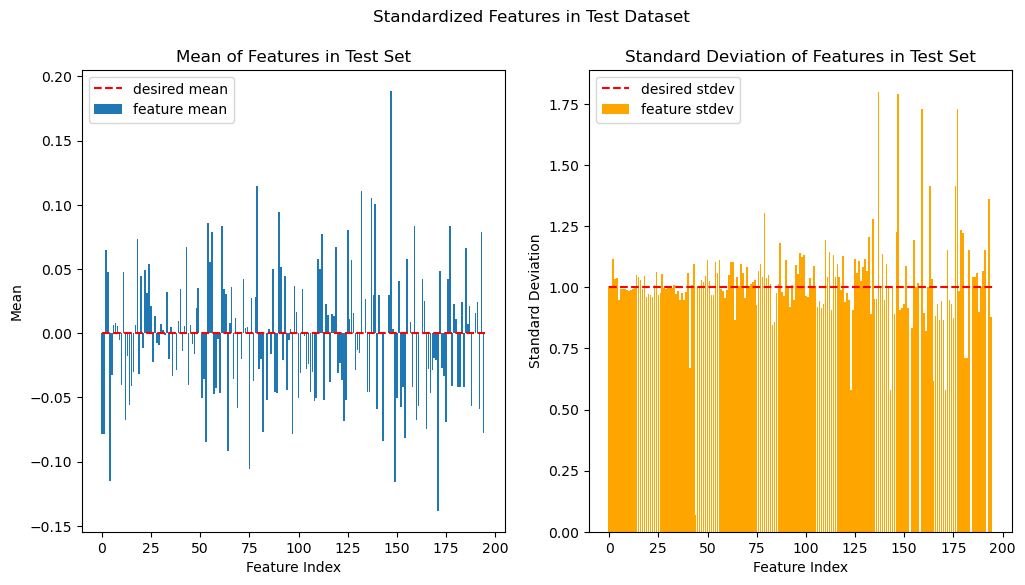

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

fig.suptitle('Standardized Features in Test Dataset')

# bar chart of means
ax[0].bar(x=torch.arange(X_test_scaled.shape[1]), height=X_test_scaled.mean(axis=0))

ax[0].hlines(y=0, xmin=0, xmax=X_test_scaled.shape[1], colors='r', linestyles='dashed')
ax[0].legend(['desired mean', 'feature mean'])

ax[0].set_title('Mean of Features in Test Set')

ax[0].set_xlabel('Feature Index')
ax[0].set_ylabel('Mean')


# bar chart of standard deviations
ax[1].bar(x=torch.arange(X_test_scaled.shape[1]), height=X_test_scaled.std(axis=0), color='orange')

ax[1].hlines(y=1, xmin=0, xmax=X_test_scaled.shape[1], colors='r', linestyles='dashed')
ax[1].legend(['desired stdev', 'feature stdev'])  

ax[1].set_title('Standard Deviation of Features in Test Set')

ax[1].set_xlabel('Feature Index')
ax[1].set_ylabel('Standard Deviation')

# Fitting One-layer KAN

In [13]:
num_features = X_train_scaled.shape[1]

torch.manual_seed(1738)

model = KANLayer(in_dim=num_features, out_dim=1)

In [14]:
# basic train and test loop
num_itrs = 500
lr = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

train_mses = torch.zeros(size=(num_itrs,))
test_mses = torch.zeros(size=(num_itrs,))

train_r2s = torch.zeros(size=(num_itrs,))
test_r2s = torch.zeros(size=(num_itrs,))

train_maes = torch.zeros(size=(num_itrs,))
test_maes = torch.zeros(size=(num_itrs,))

train_rmses = torch.zeros(size=(num_itrs,))
test_rmses = torch.zeros(size=(num_itrs,))

for i in range(num_itrs):
    optimizer.zero_grad()

    y_hat, preacts, postacts, postspline = model(X_train_scaled) # dont need the other 3 but keeping them so I dont forget what they are
    y_hat = y_hat.squeeze()

    train_mse = F.mse_loss(y_hat, y_train)
    train_mae = F.l1_loss(y_hat.detach(), y_train)
    train_rmse = torch.sqrt(train_mse.detach())
    train_r2 = 1 - (torch.sum((y_train - y_hat.detach())**2) / torch.sum((y_train - torch.mean(y_train))**2))

    # so that pytorch actually trains this thing, lol
    assert train_mse.requires_grad and y_hat.requires_grad
    assert not train_mae.requires_grad and not train_rmse.requires_grad and not train_r2.requires_grad
    
    train_mse.backward()
    optimizer.step()

    train_mses[i] = train_mse.detach()
    train_maes[i] = train_mae
    train_rmses[i] = train_rmse
    train_r2s[i] = train_r2

    # test
    y_hat, preacts, postacts, postspline = model(X_test_scaled)
    y_hat = y_hat.squeeze()

    test_loss = F.mse_loss(y_hat, y_test)
    test_mae_loss = F.l1_loss(y_hat, y_test)
    test_rmse_loss = torch.sqrt(test_loss)
    
    y_hat_detached = y_hat.detach()
    test_r2 = 1 - (torch.sum((y_test - y_hat_detached)**2) / torch.sum((y_test - torch.mean(y_test))**2))

    test_mses[i] = test_loss.detach()
    test_maes[i] = test_mae_loss.detach()
    test_rmses[i] = test_rmse_loss.detach()
    test_r2s[i] = test_r2

    if i % 50 == 0:
        print(f'train iteration {i}, loss: {train_mse.item()}, r2: {train_r2.item()}, mae: {train_mae.item()}, rmse: {train_rmse.item()}')
        print(f'test iteration {i}, loss: {test_loss.item()}, r2: {test_r2.item()}, mae: {test_mae_loss.item()}, rmse: {test_rmse_loss.item()}')

train iteration 0, loss: 13.058320999145508, r2: -2.1904282569885254, mae: 3.0461559295654297, rmse: 3.6136298179626465
test iteration 0, loss: 11.40688419342041, r2: -1.435302972793579, mae: 2.7452993392944336, rmse: 3.377408027648926
train iteration 50, loss: 0.38655585050582886, r2: 0.9055560827255249, mae: 0.4850955307483673, rmse: 0.6217361688613892
test iteration 50, loss: 0.7481517791748047, r2: 0.8402739763259888, mae: 0.625292956829071, rmse: 0.8649576902389526
train iteration 100, loss: 0.21790538728237152, r2: 0.9467610120773315, mae: 0.35732516646385193, rmse: 0.4668033719062805
test iteration 100, loss: 0.5880429148674011, r2: 0.8744562864303589, mae: 0.5309478640556335, rmse: 0.7668395638465881
train iteration 150, loss: 0.14837881922721863, r2: 0.9637478590011597, mae: 0.2976026237010956, rmse: 0.38519972562789917
test iteration 150, loss: 0.5563474297523499, r2: 0.8812230825424194, mae: 0.5142459273338318, rmse: 0.7458869814872742
train iteration 200, loss: 0.1084018424

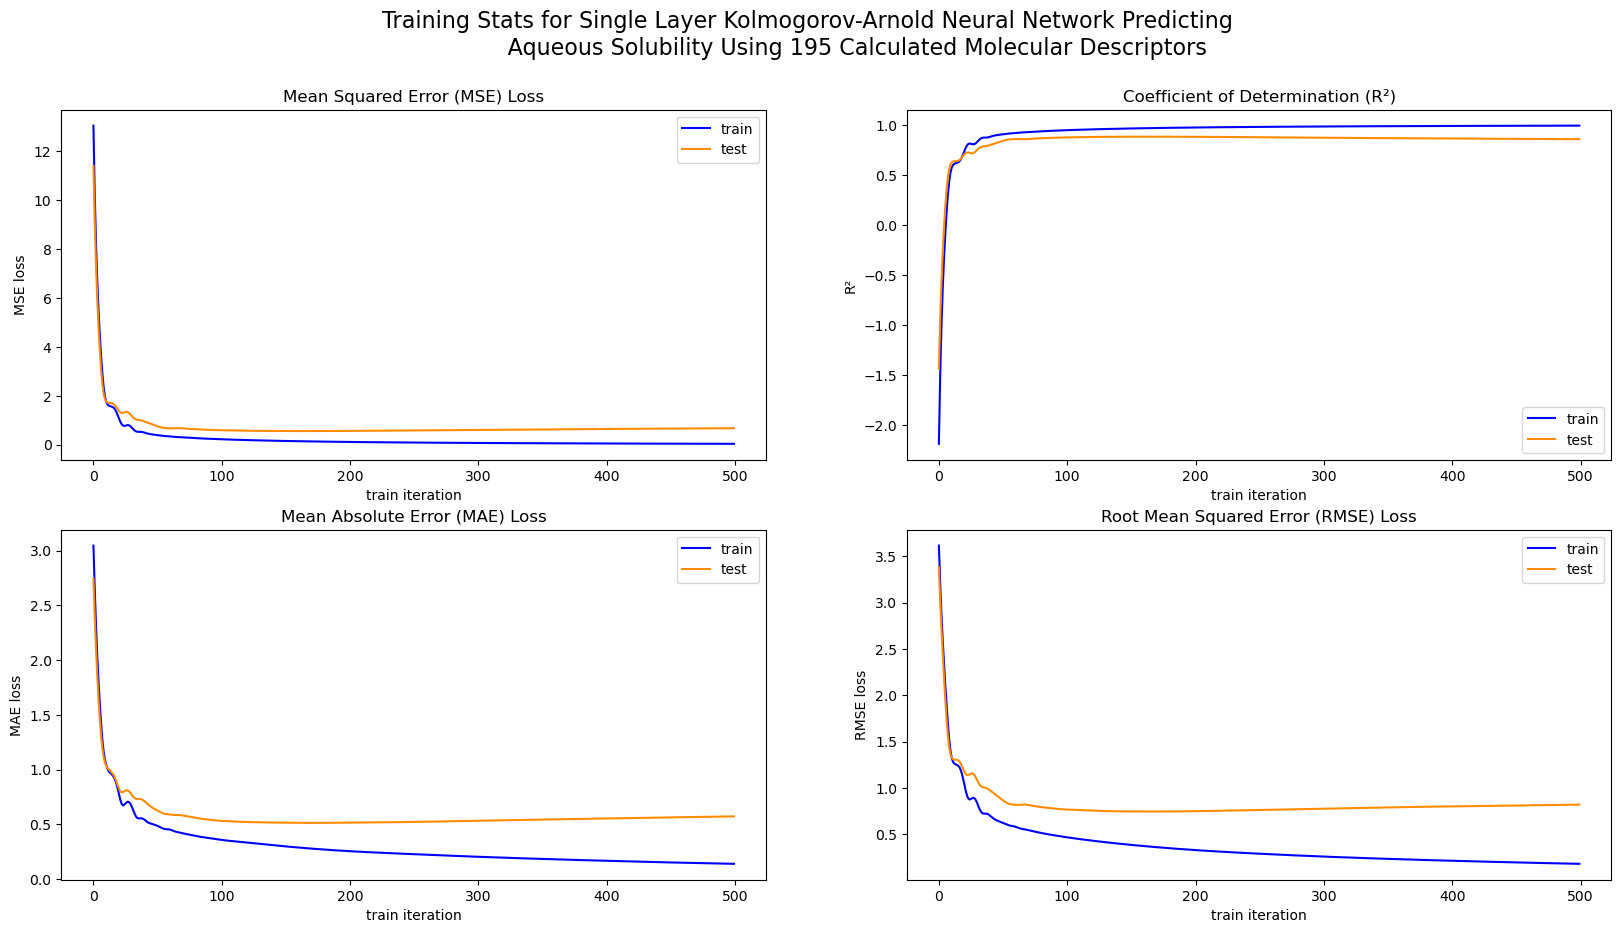

In [15]:
# plot losses and r2 for train and test
fig, ax = plt.subplots(2, 2, figsize=(20, 10))

plt.suptitle(f'''Training Stats for Single Layer Kolmogorov-Arnold Neural Network Predicting 
             Aqueous Solubility Using {X_train_scaled.shape[1]} Calculated Molecular Descriptors''', fontsize=16)

# mse plot
ax[0, 0].plot(train_mses, c='blue')
ax[0, 0].plot(test_mses, c='darkorange')
ax[0, 0].set_title('Mean Squared Error (MSE) Loss')
ax[0, 0].set_xlabel('train iteration')
ax[0, 0].set_ylabel('MSE loss')
ax[0, 0].legend(['train', 'test'])

# r2 plot
ax[0, 1].plot(train_r2s, c='blue')
ax[0, 1].plot(test_r2s, c='darkorange')
ax[0, 1].set_title('Coefficient of Determination (R\u00b2)')
ax[0, 1].set_xlabel('train iteration')
ax[0, 1].set_ylabel('R\u00b2')
ax[0, 1].legend(['train', 'test'])

# mae plot
ax[1, 0].plot(train_maes, c='blue')
ax[1, 0].plot(test_maes, c='darkorange')
ax[1, 0].set_title('Mean Absolute Error (MAE) Loss')
ax[1, 0].set_xlabel('train iteration')
ax[1, 0].set_ylabel('MAE loss')
ax[1, 0].legend(['train', 'test'])

# rmse plot
ax[1, 1].plot(train_rmses, c='blue')
ax[1, 1].plot(test_rmses, c='darkorange')
ax[1, 1].set_title('Root Mean Squared Error (RMSE) Loss')
ax[1, 1].set_xlabel('train iteration')
ax[1, 1].set_ylabel('RMSE loss')
ax[1, 1].legend(['train', 'test'])

In [16]:
# all the best objective function values for the test set
test_mses.min(), test_maes.min(), test_rmses.min(), test_r2s.max()

(tensor(0.5551), tensor(0.5128), tensor(0.7451), tensor(0.8815))